In [1]:
import os

base_path = "dataset"

folders = ["2_crawling","3_crying","4_dancing","5_eating","7_falling_slide","8_falling","9_playing_w_animals","10_playing_w_toy","12_smiling","15_walking"]

video_label_dict = {}

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith(".mp4"):
            video_path = os.path.join(folder_path, file)
            video_label_dict[video_path] = folder

print(video_label_dict)

{'dataset/2_crawling/crawling016.mp4': '2_crawling', 'dataset/2_crawling/crawling022.mp4': '2_crawling', 'dataset/2_crawling/crawling017.mp4': '2_crawling', 'dataset/2_crawling/crawling007.mp4': '2_crawling', 'dataset/2_crawling/crawling061.mp4': '2_crawling', 'dataset/2_crawling/crawling070.mp4': '2_crawling', 'dataset/2_crawling/crawling076.mp4': '2_crawling', 'dataset/2_crawling/crawling006.mp4': '2_crawling', 'dataset/2_crawling/crawling060.mp4': '2_crawling', 'dataset/2_crawling/crawling004.mp4': '2_crawling', 'dataset/2_crawling/crawling036.mp4': '2_crawling', 'dataset/2_crawling/crawling074.mp4': '2_crawling', 'dataset/2_crawling/crawling067.mp4': '2_crawling', 'dataset/2_crawling/crawling003.mp4': '2_crawling', 'dataset/2_crawling/crawling035.mp4': '2_crawling', 'dataset/2_crawling/crawling010.mp4': '2_crawling', 'dataset/2_crawling/crawling054.mp4': '2_crawling', 'dataset/2_crawling/crawling001.mp4': '2_crawling', 'dataset/2_crawling/crawling019.mp4': '2_crawling', 'dataset/2_

In [2]:
video_label_list = list(video_label_dict.items())
video_paths = list(video_label_dict.keys())
video_labels = list(video_label_dict.values())

In [3]:
from sklearn.preprocessing import LabelEncoder
label_mapping = {
    "2_crawling": 0,
    "3_crying": 1,
    "4_dancing": 2,
    "5_eating": 3,
    "7_falling_slide": 4,
    "8_falling": 5,
    "9_playing_w_animals": 6,
    "10_playing_w_toy": 7,
    "12_smiling": 8,
    "15_walking": 9,
}
label_encoder = LabelEncoder()
label_encoder.fit([label_mapping[label] for label in video_labels])
labels_encoder = label_encoder.transform([label_mapping[label] for label in video_labels])

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training (70%) and temporary (30%) sets
train_video_paths, test_video_paths, train_video_labels, test_video_labels = train_test_split(
    video_paths, labels_encoder, test_size=0.3, stratify=video_labels, random_state=42
)

# Split the temporary data into testing (20% of original data) and validation (10% of original data) sets
val_video_paths, test_video_paths, val_video_labels, test_video_labels = train_test_split(
    test_video_paths, test_video_labels, test_size=2/3, stratify=test_video_labels, random_state=42
)

In [5]:
len(train_video_paths)

213

In [6]:
len(test_video_paths)

62

In [7]:
len(val_video_paths)

30

In [8]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import torch.nn as nn


from PIL import Image
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, num_frames, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        selected_frames = self._get_video_frames(video_path)
        label = self.labels[idx]
        
        if self.transform:
            preprocessed_frames = [self.transform(frame) for frame in selected_frames]
            video_frames = torch.cat(preprocessed_frames, dim=1)


        return video_frames, label, video_path

#     def _get_video_frames(self, video_path):
#         frames = []
#         video = cv2.VideoCapture(video_path)
#         while len(frames) < self.num_frames:
#             ret, frame = video.read()
#             if not ret:
#                 break
#             image = Image.fromarray(frame)
#             frames.append(image)
#         video.release()
#         return frames
    
    def _get_video_frames(self, video_path):
        frames = []
        video = cv2.VideoCapture(video_path)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

        frame_indices = np.linspace(0, total_frames-1, self.num_frames, dtype=int)

        for frame_index in frame_indices:
            video.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = video.read()
            if not ret:
                break
            image = Image.fromarray(frame)
            frames.append(image)
        video.release()
        return frames


In [9]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [10]:
train_dataset = VideoDataset(train_video_paths, train_video_labels, num_frames=16, transform=preprocess)
test_dataset = VideoDataset(test_video_paths, test_video_labels, num_frames=16, transform=preprocess)
val_dataset = VideoDataset(val_video_paths, val_video_labels, num_frames=16, transform=preprocess)

In [11]:
data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

In [12]:
import torch
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),  # Dropout layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),  # Dropout layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),  # Dropout layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),  # Dropout layer
        )
        self.fc = nn.Linear(128 * 224 * 14, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Example usage
model = ConvNet(num_classes=10)  # Replace `num_classes` with the number of classes in your classification task




In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay =0.001)

In [14]:
import matplotlib.pyplot as plt
# Create lists to store the loss and accuracy values
train_loss_values = []
train_acc_values = []
test_loss_values = []
test_acc_values = []

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the device
model = model.to(device)


# Set the number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    for inputs, labels, _ in data_loader_train:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels)

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(data_loader_train.dataset)
    train_acc = correct_predictions.double() / len(data_loader_train.dataset) *100
    
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc/100)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels, _ in data_loader_test:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            correct_predictions += torch.sum(preds == labels)

    test_loss = running_loss / len(data_loader_test.dataset)
    test_acc = correct_predictions.double() / len(data_loader_test.dataset) *100
    
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc/100)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch 1/10: Train Loss: 2.5492, Train Acc: 12.68%, Test Loss: 2.1229, Test Acc: 22.58%
Epoch 2/10: Train Loss: 1.9984, Train Acc: 30.52%, Test Loss: 1.9053, Test Acc: 35.48%
Epoch 3/10: Train Loss: 1.6161, Train Acc: 48.36%, Test Loss: 1.7345, Test Acc: 43.55%
Epoch 4/10: Train Loss: 1.1607, Train Acc: 65.26%, Test Loss: 1.6204, Test Acc: 43.55%
Epoch 5/10: Train Loss: 0.7659, Train Acc: 83.10%, Test Loss: 1.5645, Test Acc: 38.71%
Epoch 6/10: Train Loss: 0.3640, Train Acc: 94.37%, Test Loss: 1.6745, Test Acc: 45.16%
Epoch 7/10: Train Loss: 0.1856, Train Acc: 97.65%, Test Loss: 2.1909, Test Acc: 29.03%
Epoch 8/10: Train Loss: 0.1169, Train Acc: 98.12%, Test Loss: 1.9802, Test Acc: 33.87%
Epoch 9/10: Train Loss: 0.0644, Train Acc: 100.00%, Test Loss: 1.9552, Test Acc: 40.32%
Epoch 10/10: Train Loss: 0.0188, Train Acc: 100.00%, Test Loss: 1.8627, Test Acc: 41.94%


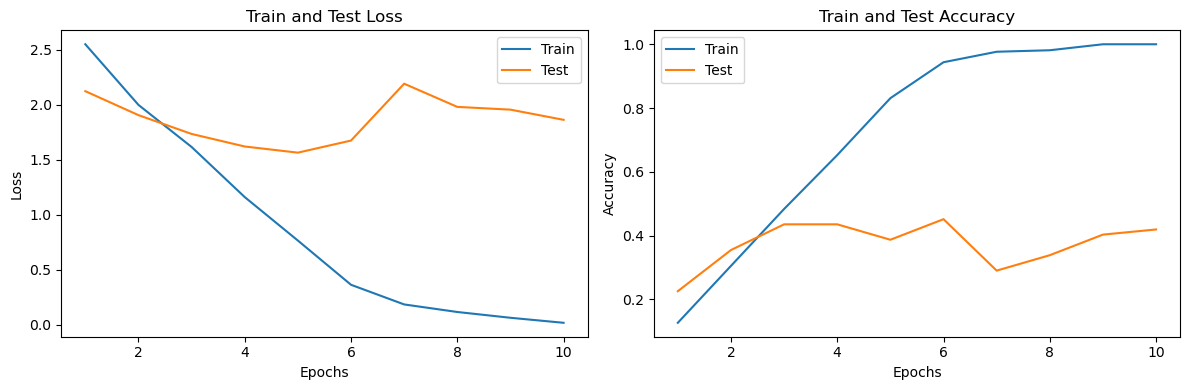

In [15]:
# Plotting the curves
epochs = range(1, num_epochs+1)


# Plotting loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, label='Train')
plt.plot(epochs, test_loss_values, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, [x.item() for x in train_acc_values], label='Train')
plt.plot(epochs, [x.item() for x in test_acc_values], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [16]:
model.eval()
running_loss = 0.0
correct_predictions_top1 = 0
correct_predictions_top5 = 0

with torch.no_grad():
    for inputs, labels, _ in data_loader_val:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        correct_predictions_top1 += torch.sum(preds == labels)
        
        # Calculate top-5 accuracy
        _, pred_labels_top5 = torch.topk(outputs, k=5, dim=1)
        correct_predictions_top5 += torch.sum(pred_labels_top5 == labels.view(-1, 1))

epoch_loss = running_loss / len(data_loader_test.dataset)
epoch_acc_top1 = correct_predictions_top1.double() / len(data_loader_val.dataset)
epoch_acc_top5 = correct_predictions_top5.double() / len(data_loader_val.dataset)

print(f"Top-1 Accuracy: {epoch_acc_top1.item() * 100:.2f}%")
print(f"Top-5 Accuracy: {epoch_acc_top5.item() * 100:.2f}%")

Top-1 Accuracy: 43.33%
Top-5 Accuracy: 86.67%


In [17]:
model.eval()
running_loss = 0.0
correct_counts = {}
total_counts = {}

with torch.no_grad():
    for inputs, labels, _ in data_loader_val:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)

        for true_label, pred_label in zip(labels, preds):
            if true_label.item() in total_counts:
                total_counts[true_label.item()] += 1
            else:
                total_counts[true_label.item()] = 1

            if true_label.item() == pred_label.item():
                if true_label.item() in correct_counts:
                    correct_counts[true_label.item()] += 1
                else:
                    correct_counts[true_label.item()] = 1

epoch_loss = running_loss / len(data_loader_val.dataset)

print("Top-1 Accuracy by True Label:")
for label in sorted(total_counts.keys()):
    accuracy = correct_counts.get(label, 0) / total_counts[label]
    print(f"True Label: {label}, Accuracy: {accuracy * 100:.2f}%")


Top-1 Accuracy by True Label:
True Label: 0, Accuracy: 66.67%
True Label: 1, Accuracy: 66.67%
True Label: 2, Accuracy: 0.00%
True Label: 3, Accuracy: 50.00%
True Label: 4, Accuracy: 50.00%
True Label: 5, Accuracy: 75.00%
True Label: 6, Accuracy: 33.33%
True Label: 7, Accuracy: 0.00%
True Label: 8, Accuracy: 33.33%
True Label: 9, Accuracy: 25.00%


In [18]:
model.eval()
running_loss = 0.0
correct_counts = {}
total_counts = {}

# Lists to store the video paths, true labels, and predicted labels
video_paths = []
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels, video_path in data_loader_val:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)

        for video_path, true_label, pred_label in zip(video_path, labels, preds):
            if true_label.item() == 2:  # Adjust the condition to match the desired true label
                # Append the video path, true label, and predicted label to the respective lists
                video_paths.append(video_path)
                true_labels.append(true_label.item())
                predicted_labels.append(pred_label.item())

print("Videos with True Label = 2:")
for video_path, true_label, predicted_label in zip(video_paths, true_labels, predicted_labels):
    print(f"Video Path: {video_path}, True Label: {true_label}, Predicted Label: {predicted_label}")

Videos with True Label = 2:
Video Path: dataset/4_dancing/dancing022.mp4, True Label: 2, Predicted Label: 4
Video Path: dataset/4_dancing/dancing010.mp4, True Label: 2, Predicted Label: 1
